# 1. 机器翻译数据集

In [1]:
import os
import torch
from d2l import torch as d2l

In [2]:
# 下载和预处理数据集
# 将数据集的下载链接和校验码与'fra-eng'标识关联起来
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                          '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """载入 “英语-法语” 数据集 """
    # 下载并解压数据集
    data_dir = d2l.download_extract('fra-eng')
    # 读取数据并返回
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()
    
# 调用函数读取数据集
raw_text = read_data_nmt()
# 打印数据集的前75个字符
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [3]:
# 几个预处理步骤
def preprocess_nmt(text):
    """预处理 “英语-法语” 数据集"""
    # 判断字符是否是特定标点符号并且前一个字符不是空格
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    # 替换特殊字符为空格，转换为小写
    text = text.replace('\u202f', ' ').replace('\xa0',' ').lower()
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char # 在特定标点符号前添加空格
        for i, char in enumerate(text)] # 遍历文本中的每个字符
    return ''.join(out) # 将处理后的字符列表转换为字符串

# 调用预处理函数处理原始文本
text = preprocess_nmt(raw_text)
# 打印处理后的文本的前80个字符
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [4]:
# 词元化
def tokenize_nmt(text, num_examples=None):
    """词元化 “英语-法语” 数据数据集 """
    # 存储英语和法语的词元序列
    source, target = [], []  
    # 遍历文本中的每一行
    for i, line in enumerate(text.split('\n')):
        # 如果指定了num_examples且超过了指定数量，则结束循环
        if num_examples and i > num_examples:
            break
        # 按制表符分割行
        parts = line.split('\t')
        # 如果行中包含了两个部分
        if len(parts) == 2:
            # 将英语部分按空格分割为词元，并添加到source列表
            source.append(parts[0].split(' ')) # 英语
            # 将法语部分按空格分割为词元，并添加到target列表
            target.append(parts[1].split(' ')) # 法语
    return source, target

# 调用函数词元化文本
source, target = tokenize_nmt(text)
# 打印source和target的前6个词元序列
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

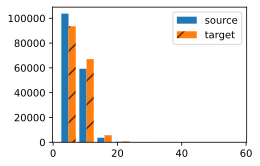

In [5]:
# 绘制每个文本序列所包含的标记数量的直方图，根据句子长度做的直方图
# 设置图形大小
d2l.set_figsize()
# 绘制每个文本序列所包含的标记数量的直方图
_, _, patches = d2l.plt.hist([[len(l)
                              for l in source], [len(l) for l in target]],
                            label = ['source','target']) # 添加标签
# 遍历第二个直方图的每个矩形
for patch in patches[1].patches:
    # 设置矩形的填充样式为斜线
    patch.set_hatch('/')
# 添加图例，位于右上角
d2l.plt.legend(loc='upper right')

In [6]:
# 词汇表
# 创建源语言的词汇表对象
src_vocab = d2l.Vocab(source, min_freq=2,
                     reserved_tokens=['<pad>','<bos>','<eos>']) # bos 表示句子开始，eos表示句子结束，min_freq=2表示句子长度小于2个就不要了  
# 计算词汇表的大小
len(src_vocab)

10012

In [7]:
# 序列样本都有一个固定长度截断或填充文本序列
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    # 如果文本序列长度超过了指定的长度
    if len(line) > num_steps:
        # 截断文本序列，取前num_steps个词元
        return line[:num_steps]
    # 填充文本序列，添加padding_token直到长度达到num_steps
    return line + [padding_token] * (num_steps - len(line))
# 对源语言的第一个文本序列进行截断或填充
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [8]:
# 转换成小批量数据集用于训练
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    # 将文本序列中的词元转换为词汇表中的索引
    lines = [vocab[l] for l in lines]
    # 每个句子后面加一个截止符'<eos>'
    lines = [l + [vocab['<eos>']] for l in lines] # 每个句子后面加了一个截止符
    # 构建小批量数据集的张量表示
    array = torch.tensor([ truncate_pad(l, num_steps, vocab['<pad>']) for l in lines ])
    # 计算原始句子的实际长度
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    # 返回小批量数据集的张量表示和实际长度
    return array, valid_len # valid_len 为原始句子的实际长度

In [9]:
# 训练模型
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表"""
    # 预处理原始数据集
    text = preprocess_nmt(read_data_nmt())
    # 对预处理后的文本进行词元化
    source, target = tokenize_nmt(text, num_examples)
    # 创建源语言词汇表对象
    src_vocab = d2l.Vocab(source, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    # 创建目标语言词汇表对象
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    # 将源语言文本序列转换为小批量数据集的张量表示和实际长度
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)  
    # 将目标语言文本序列转换为小批量数据集的张量表示和实际长度
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    # 构建数据集的张量表示和实际长度的元组
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    # 加载数据集并创建迭代器
    data_iter = d2l.load_array(data_arrays, batch_size)
    # 返回数据迭代器和源语言、目标语言的词汇表对象
    return data_iter, src_vocab, tgt_vocab

In [10]:
# 读出 “英语-法语” 数据集中第一个小批量数据
# 加载翻译数据集的迭代器和词汇表，设置每个小批量的大小和序列长度
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)  
# 遍历数据迭代器，获取每个小批量的数据和有效长度
for X, X_valid_len, Y, Y_valid_len in train_iter:
    # 打印源语言序列的张量表示（整数类型）
    print('X:', X.type(torch.int32))
    # 打印源语言序列的有效长度
    print('valid lengths for X:', X_valid_len)
    # 打印目标语言序列的张量表示（整数类型）
    print('Y:', Y.type(torch.int32))
    # 打印目标语言序列的有效长度
    print('valid lengths for Y:', Y_valid_len)
    # 跳出循环，只打印第一个小批量数据
    break

X: tensor([[83, 15,  4,  3,  1,  1,  1,  1],
        [69, 17,  9, 11,  3,  1,  1,  1]], dtype=torch.int32)
valid lengths for X: tensor([4, 5])
Y: tensor([[  0,   5,   3,   1,   1,   1,   1,   1],
        [ 90, 172,   9,   3,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for Y: tensor([3, 4])
